### Generative story 

- Generative models have some theory about how data observed in the world was generated. 
- We have been looking at one important generative model, naive Bayes
- Let's look at how naive Bayes models data observed in the world
- The model here is know as "Gaussian naive Bayes" because we assume the features are normally distributed (i.e. with Gaussians)

In [15]:
import random
import numpy as np
import pandas as pd


# generative models can generate data. Let's generate one point
def generatePoint(p, mu11, mu12, mu21, mu22, dogSD, catSD):
    '''
    Generate one point with two Gaussian features, conditioned on a class

    p = probability of class 1
    mu11 = Mean of feature 1, class 1
    mu12 = Mean of feature 1, class 2
    mu21 = Mean of feature 2, class 1
    mu22 = Mean of feature 2, class 2
    '''
    SD = 1 # assume standard deviation of 1
    label = None
    feature1 = None
    if (random.random() < p):
        label = "cat"
        height = np.random.normal(mu11, catSD, size=1)[0]
        weight = np.random.normal(mu12, catSD, size=1)[0]
    else:
        label = "dog"
        height = np.random.normal(mu21, dogSD, size=1)[0]
        weight = np.random.normal(mu22, dogSD, size=1)[0]
    return {"label": label, "height": height, "weight": weight}
    

# height in inches, weight in pounds
theta = {"p(Y=cat)": .6, "dog_mu_height": 20, "dog_mu_weight": 50, 
         "dogSD": 10, "catSD": 2, "cat_mu_height": 6, "cat_mu_weight": 9}

points = []
for i in range(100):

    p = generatePoint(p=theta["p(Y=cat)"], mu11=theta["cat_mu_height"], dogSD=theta["dogSD"], catSD=theta["catSD"],
                      mu12=theta["cat_mu_weight"], mu21=theta["dog_mu_height"], mu22=theta["dog_mu_weight"])
    
    points.append(p)

df = pd.DataFrame(points)

df

,label,height,weight
0,cat,6.375636,10.497257
1,cat,1.759638,13.320037
2,cat,8.259552,10.717193
3,dog,17.644864,40.487721
4,cat,2.328081,10.072252
...,...,...,...
95,cat,5.937577,10.493530
96,dog,7.897894,52.422734
97,dog,29.257206,50.535273
98,cat,3.501942,7.339525


### Question 

#### What is happening in the method "generatePoint" ?

It generates the features from a Normal distribution conditioned on a label.


#### What happens if you vary p(Y=cat)?

It increses the probability that a given point is labeled cat in the generated data.

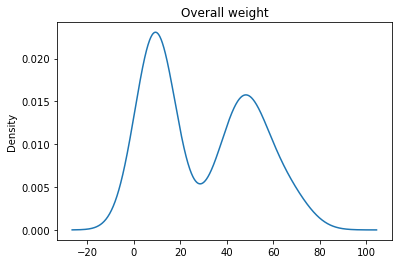

In [16]:
df["weight"].plot.kde(title="Overall weight")

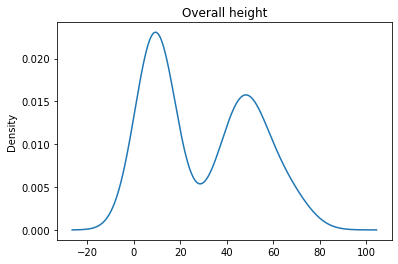

In [22]:
df["weight"].plot.kde(title="Overall height")

[Text(0.5, 0, 'Inches')]

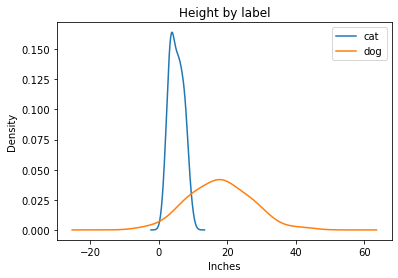

In [21]:
fig, ax = df.groupby("label")["height"].plot.kde(legend=True)
ax.set_title('Height by label') 
ax.set(xlabel='Inches')

[Text(0.5, 0, 'Pounds')]

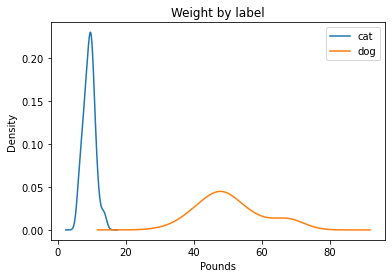

In [20]:
fig, ax = df.groupby("label")["weight"].plot.kde(legend=True)
ax.set_title('Weight by label')
ax.set(xlabel='Pounds')

### Question

#### What do you observe in the plots called "Overall weight" and "Overall height"? Why do you think the plots have this shape? 

They are bimodal beacuse the data is drawn from two different distributions associated with 'cat' and 'dog'

#### What happens to these plots if you vary the parameters? 

They change in shape based on the mean and standard deviation.

### Question

#### What do you observe in the plots called "Height by animal" and "Weight by animal"? 
#### Why do you think the plots have this shape? 

[Type your answer here]

#### What happens to these plots if you vary the parameters? 

[Type your answer here]

### Likelihood

Naive Bayes assumes that all features are generated independently. That means that the probability of drawing an observation like ``{animal=dog, weight=13, height=30}`` is `p(animal=dog)*p(weight=13|dog)*p(height=30|dog)`. 

In [23]:
from scipy.stats import norm

def BernoulliProbOnePoint(p, x_i):
    '''
    return the probability of x_i, according to the Bernoulli distribution with parameter p
    '''
    if x_i == 1:
        return p
    else:
        return 1 - p 
    
def GaussianProbOneFeature(mu, sigma, observation):
    return norm(loc=mu, scale=sigma).pdf(observation)

In [24]:
def log_probability_of_one_point(point, theta):
    p_point = BernoulliProbOnePoint(p=theta["p(Y=cat)"], x_i=point["label"] == "cat")

    height = point["height"]
    weight = point["weight"]

    if point["label"] == "dog":
        pheight = GaussianProbOneFeature(mu=theta["dog_mu_height"], sigma=theta["dogSD"], observation=height)
        pweight = GaussianProbOneFeature(mu=theta["dog_mu_weight"], sigma=theta["dogSD"], observation=weight)
    else:
        pheight = GaussianProbOneFeature(mu=theta["cat_mu_height"], sigma=theta["catSD"], observation=height)
        pweight = GaussianProbOneFeature(mu=theta["cat_mu_weight"], sigma=theta["catSD"], observation=weight)
        
    return np.log(p_point) + np.log(pheight) + np.log(pweight)

def log_likelihood(points, theta):
    sum_ = 0
    for point in points:
        sum_ += log_probability_of_one_point(point, theta=theta)
    return sum_

ll = log_likelihood(points, theta)

### Question 

#### What is happening in "log_likelihood"  function?

[Type your answer here]

### Classification

#### In naive Bayes, we apply Bayes rule to classify points based on which class is most probable 

$p(Y|X) \propto p(X|Y)p(Y)$

Use this expression and the function `log_probability_of_one_point` to classify a random point. Does the classification make sense? Some starter code is provided below

In [27]:
random_point = generatePoint(p=theta["p(Y=cat)"], mu11=theta["cat_mu_height"], dogSD=theta["dogSD"], catSD=theta["catSD"],
                             mu12=theta["dog_mu_weight"], mu21=theta["cat_mu_height"], mu22=theta["cat_mu_weight"])

x = log_probability_of_one_point(random_point, theta)
print(x)



real_label = random_point["label"]

print("real_label = {}".format(real_label))

for possible_label in ["cat", "dog"]:
    random_point["label"] = possible_label

-16.330840316130097
real_label = dog


### Learning

In reality, you would fit Gaussian naive Bayes using maximum likelihood estimation (MLE). There are closed-form expressions for the MLE of each parameter. You can look them up. But we can try to optimize with random seach. You would not want to do this in practice, but it's very helpful for understanding what is going on. Although random search is inefficient, it is easy to implement and requires no math! Try generating parameters at random in a variable called `theta_guess` and then computing the likelihood. It might be helpful to only vary one parameter at a time. What do you observe about the values of `theta_guess` and `theta`?